# Visualize attention maps
https://github.com/huggingface/pytorch-image-models/discussions/1232

In [1]:
import os
import sys
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F
from torch.nn.functional import cosine_similarity

import numpy as np
import cv2

import wandb
import matplotlib.pyplot as plt

# To add src to the path so that we can import modules
current_directory = os.getcwd()
if not current_directory.endswith("emotion_recognition"):
    sys.path.append(os.path.join(current_directory, 'emotion_recognition'))

try:
    from src import RAW_AFFECTNET_DIR, MODELS_DIR
    from src.data.dataset import create_dataloader
    import src.models.architectures as arch
    from src.data.dataset import data_transforms
    from config import wandbAPIkey
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)


In [2]:
def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap='magma')
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(2, 2))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha, cmap='magma')
    plt.axis('off')
    plt.show()

def attention_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

Get model from wandb

In [3]:
wandb.login(key=wandbAPIkey)
api = wandb.Api()
artifact_dir = arch.get_wandb_artifact("daily-sweep-20", api = api)
local_artifact = torch.load(os.path.join(artifact_dir, "model_best.pt"))
params = local_artifact["params"]
emotion_model, device = arch.model_creation(params['arch'], local_artifact['state_dict'])
emotion_model_2, device = arch.model_creation(params['arch'], local_artifact['state_dict'], device = device)
emotion_model.eval()
emotion_model_2.eval()
# Load the face transforms
face_transforms = data_transforms(only_normalize = True, image_norm = params['image_norm'], resize = True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: armand-07. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\arman\.netrc


Using FER trained model: daily-sweep-20


wandb: Downloading large artifact model_daily-sweep-20:latest, 327.41MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.7


Artifact downloaded to: c:\Users\arman\Desktop\emotion_recognition\notebooks\artifacts\model_daily-sweep-20-v0
Using CUDA with 1 GPUs
Using CUDA device:NVIDIA GeForce RTX 3060
Creating FER model with architecture: deit_base
Using imagenet pre-trained weights: False
Using custom weights of type <class 'collections.OrderedDict'>: 
Creating FER model with architecture: deit_base
Using imagenet pre-trained weights: False
Using custom weights of type <class 'collections.OrderedDict'>: 


Load image from test.

In [4]:
val_path = os.path.join(RAW_AFFECTNET_DIR, "val_set")
val_path_annotation = os.path.join(val_path, "annotations")
val_path_images = os.path.join(val_path, "images")

selected_id = 10
image_filename = [img for img in os.listdir(val_path_images) if img.split('.')[0] == str(selected_id)][0]
image_path = os.path.join(val_path_images, image_filename)
print(image_path)
img = cv2.imread(image_path)                    # In BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Convert from BGR to RGB
img_inference = face_transforms(image=img)["image"].unsqueeze(0).to(device)

C:\Users\arman\Desktop\emotion_recognition\data\affectnet\raw\val_set\images\10.jpg


c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


(tensor([[ 1.6638, -0.1390, -0.3429, -2.3784, -2.1801,  0.2865,  0.3755,  3.1816]],
       device='cuda:0'), tensor([[ 1.5151,  0.2049,  0.5472, -1.8974, -2.0192, -0.8695,  1.0192,  2.5411]],
       device='cuda:0'))
torch.Size([198, 198])
torch.Size([1, 14, 14])
torch.Size([224, 224, 1])


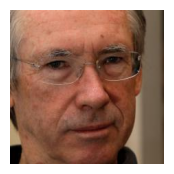

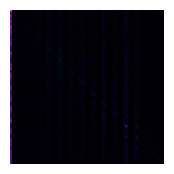

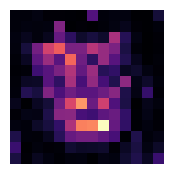

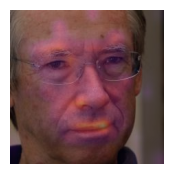

In [5]:
selected_layer = 11
emotion_model.base_model.blocks[selected_layer].attn.forward = attention_forward_wrapper(emotion_model.base_model.blocks[selected_layer].attn)

with torch.no_grad():
    y = emotion_model(img_inference)
    print(y)
attn_map = emotion_model.base_model.blocks[selected_layer].attn.attn_map.mean(dim=1).squeeze(0).detach().to('cpu')
cls_weight = emotion_model.base_model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(-1, 14, 14).detach().to('cpu')
print(attn_map.shape) # attention map for last layer (198 x 198 (=196(14x14 img) + 1(cls) + 1(distill)))
print(cls_weight.shape) 

cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
print(cls_resized.shape)

show_img(img)
show_img(attn_map) 
show_img(cls_weight[0])
show_img2(img, cls_resized, alpha=0.35)

In [6]:
dataloader_test = create_dataloader(datasplit = "test", batch_size = 128, 
                                        image_norm = params['image_norm'], num_workers = 2)
# Create an iterator from the dataloader
data_iter = iter(dataloader_test)

Normal dataloader created for test datasplit
Transforms: Compose([
  Normalize(always_apply=False, p=1.0, mean=tensor([0.5694, 0.4460, 0.3911]), std=tensor([0.2746, 0.2446, 0.2383]), max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [7]:
batch = next(data_iter)
imgs = batch[0].to(device)

Block 0
Block 1
Block 2
Block 3
Block 4
Block 5
Block 6
Block 7
Block 8
Block 9
Block 10
Block 11





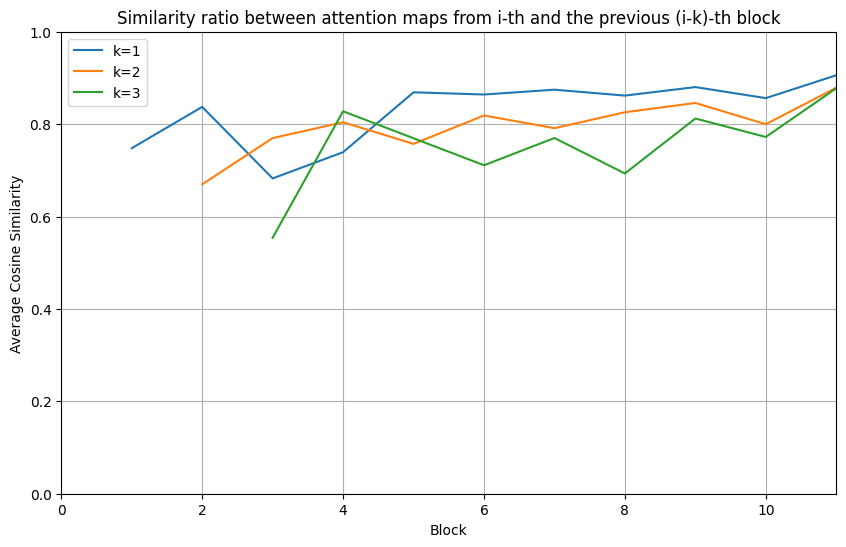

In [8]:
# Define your k values
k_values = [1, 2, 3]

# Initialize a dictionary to store average similarities for each k
avg_similarities = {k: [] for k in k_values}

# Assuming `model` is your pretrained Vision Transformer
for block in emotion_model_2.base_model.blocks:
    block.attn.forward = attention_forward_wrapper(block.attn)

# Now, when you run your model, the attention maps will be saved in each block
output = emotion_model_2(imgs)


# Initialize a list to store all attention maps
attention_maps = []

for i, block in enumerate(emotion_model_2.base_model.blocks):
    print(f"Block {i}")
    attn_map = block.attn.attn_map.mean(dim=1).squeeze(0).detach().to('cpu')
    
    # Append the attention map to the list
    attention_maps.append(attn_map)

for i, attn_map in enumerate(attention_maps):
    for k in k_values:
        if k <= i:
            # Compute cosine similarity for each token with other tokens
            cos_sim = cosine_similarity(attention_maps[i], attention_maps[i-k], dim=-1)
            avg_sim = cos_sim.mean().item()
            avg_similarities[k].append(avg_sim)
total_blocks = len(attention_maps)

fig, ax = plt.subplots(figsize=(10, 6))

for k, similarities in avg_similarities.items():
    ax.plot(range(k, total_blocks), similarities, label=f'k={k}')
    print()

ax.set_xlabel('Block')
ax.set_xlim([0, total_blocks-1])
ax.set_ylim([0, 1])
ax.set_title("Similarity ratio between attention maps from i-th and the previous (i-k)-th block")
ax.set_ylabel('Average Cosine Similarity')
ax.legend()
ax.grid(True)

plt.show()